In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
import numpy as np
import elfi # install cython -> conda install cython to avoid fallback to numpy
import scipy.stats as ss
import pylab as plt
%matplotlib notebook

warning in stationary: failed to import cython module: falling back to numpy


### The simulation model

In [2]:
def simulator(mu, sigma, batch_size=1, random_state=None):
    mu, sigma = np.atleast_1d(mu, sigma)
    return ss.norm.rvs(mu[:, None], sigma[:, None], size=(batch_size, 30), random_state=random_state)

def mean(y):
    return np.mean(y, axis=1)

def var(y):
    return np.var(y, axis=1)

### Observed data

In [3]:
# Set the generating parameters that we will try to infer
mean0 = 1
std0 = 3

# Generate some data (using a fixed seed here)
np.random.seed(20170525)
y0 = simulator(mean0, std0)
print(y0)

[[ 3.7990926   1.49411834  0.90999905  2.46088006 -0.10696721  0.80490023
   0.7413415  -5.07258261  0.89397268  3.55462229  0.45888389 -3.31930036
  -0.55378741  3.00865492  1.59394854 -3.37065996  5.03883749 -2.73279084
   6.10128027  5.09388631  1.90079255 -1.7161259   3.86821266  0.4963219
   1.64594033 -2.51620566 -0.83601666  2.68225112  2.75598375 -6.02538356]]


### Elfi class

In [4]:
# Prior
elfi.new_model() # important to reset, otherwise rerun the code will produce two nodes for S1, S2 and so on
mu = elfi.Prior('uniform', -2, 4)
sigma = elfi.Prior('uniform', 1, 4)

# Add the simulator node and observed data to the model
sim = elfi.Simulator(simulator, mu, sigma, observed=y0)

# Add summary statistics to the model
S1 = elfi.Summary(mean, sim, name="mean")
S2 = elfi.Summary(var, sim, name="var")

# Specify distance as euclidean between summary vectors (S1, S2) from simulated and
# observed data
d = elfi.Distance('euclidean', S1, S2)

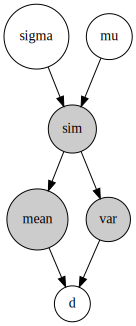

In [5]:
# Plot the complete model (requires graphviz)
elfi.draw(d)

### Rejection Sampler

In [6]:
rej = elfi.Rejection(d, batch_size=10000, seed=30052017)
res = rej.sample(1000, threshold=.5)
print(res)

Method: Rejection
Number of samples: 1000
Number of simulations: 120000
Threshold: 0.492
Sample means: mu: 0.748, sigma: 3.1



<IPython.core.display.Javascript object>


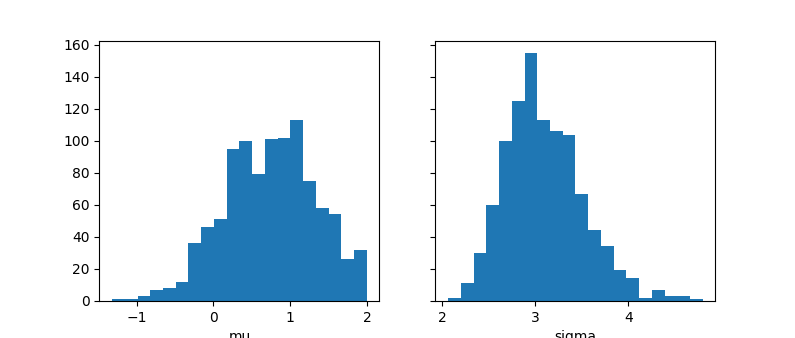

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f369c284a90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f369c2c1ac8>], dtype=object)

In [9]:
res.plot_marginals()

### Own class

In [11]:
# setup
mu = lambda: np.random.uniform(-2,2)
sigma = lambda: np.random.uniform(1,5)

rej_samp = pyabc.RejectionSampler(
    priors=[mu, sigma], 
    simulator=simulator, 
    summaries=[mean, var],
    observation=y0, 
    seed=30052017
)

In [15]:
rej_samp.sample(nr_samples=1000, threshold=.5)

Rejection sampler started with threshold: 0.5 and number of samples: 1000
Samples:   1000 - Threshold: 0.50 - Iterations:     116744 - Time:    19.57 s


<IPython.core.display.Javascript object>


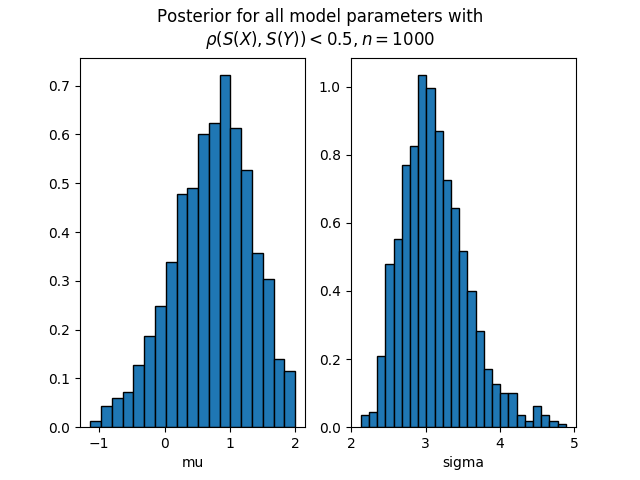

In [13]:
names = ["mu", "sigma"]
rej_samp.plot_marginals(names)

In [14]:
# sample means
for theta in rej_samp.Thetas.T:
    print(theta.mean())

0.729485844082
3.12692101806
